In [109]:
from IPython.display import clear_output
!pip install -U fsds_100719
clear_output()
from fsds_100719.imports import *


In [110]:
import warnings
warnings.filterwarnings('ignore')

# Functions

In [111]:
# import wordcloud
# from wordcloud import WordCloud
# wordcloud = WordCloud(collocations=False)#stopwords=stopwords_list,
# wordcloud.generate(','.join(text_clf))
# plt.figure(figsize = (12, 12), facecolor = None) 
# plt.imshow(wordcloud) 
# plt.axis('off')

In [112]:
def evaluate_model(clf, y_trn, y_true, y_pred, X_trn, X_true):
    
    '''
    Calculates and displays the following: Train and Test Score, Classification Report, 
    Confusion Matrix, ROC Curve, and Importance Series.
    
        Parameters:
            
            clf: classifier or instanciated model from run_model function
            y_trn: y train from test, train, split
            y_true: y test from test, train, split
            y_pred: y hat test from run_model fuction
            X_trn: X train from test, train, split
            X_true: X test from test, train, split
    
    '''
    # Calculates and displays train and test scores.
    train_score = clf.score(X_trn,y_trn)
    test_score = clf.score(X_true,y_true)
    print(f"Train score= {train_score}")
    print(f"Test score= {test_score}\n")
    
    # Displays Classification Report / Scores 
    print(metrics.classification_report(y_true,y_pred))
    
    # Displays Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,4))
    metrics.plot_confusion_matrix(clf,X_true,y_true,cmap="Reds",
                                  normalize='true',ax=ax)
    ax.set(title='Confusion Matrix')
    ax.grid(False)
    

# EDA

In [113]:
data = pd.read_csv('product_review.csv',encoding= 'unicode_escape')

In [114]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [115]:
# Rename columns for ease to work with.

data.rename(columns={'tweet_text': 'tweet', 'emotion_in_tweet_is_directed_at': 'product', 'is_there_an_emotion_directed_at_a_brand_or_product':'emotion'}, inplace=True)

In [116]:
data.shape

(9093, 3)

In [117]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet      9092 non-null object
product    3291 non-null object
emotion    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [118]:
# Most of the null data is in the product column.

data.isnull().sum()

tweet         1
product    5802
emotion       0
dtype: int64

In [119]:
data.fillna('unknown', inplace=True)

In [120]:
emotion_dict = dict({"No emotion toward brand or product":"Neutral","Positive emotion":"Positive", "Negative emotion":"Negative", "I can't tell":"I can't tell"})

In [121]:
data['emotion'] = data['emotion'].map(emotion_dict)

In [122]:
data['emotion'].value_counts()

Neutral         5389
Positive        2978
Negative         570
I can't tell     156
Name: emotion, dtype: int64

In [123]:
data.isnull().sum()

tweet      0
product    0
emotion    0
dtype: int64

In [124]:
# Convert "tweet" data into string format.

data["tweet"]= data["tweet"].astype(str) 

In [125]:
# Add "text length" feature.

data['text length'] = data['tweet'].apply(len)

In [126]:
# Add "token length" feature.

data['token_length'] = [len(x.split(" ")) for x in data.tweet]
max(data.token_length)

33

In [127]:
data.isnull().sum()

tweet           0
product         0
emotion         0
text length     0
token_length    0
dtype: int64

In [128]:
data.shape

(9093, 5)

In [129]:
# Identify target variables.

data['emotion'].value_counts()

Neutral         5389
Positive        2978
Negative         570
I can't tell     156
Name: emotion, dtype: int64

In [130]:
bad_rows = data['emotion']== "I can't tell"

In [131]:
# Eliminate "I can't tell" variable.

data = data[~bad_rows]

In [132]:
data['emotion'].value_counts()

Neutral     5389
Positive    2978
Negative     570
Name: emotion, dtype: int64

## Plot Numeric Features

In [133]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

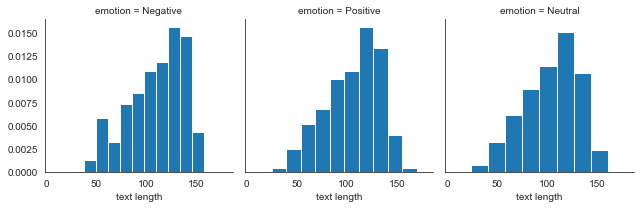

In [134]:
a = sns.FacetGrid(data,col='emotion')
a.map(plt.hist,'text length', density=True)

Plot shows similar distribution of "text length" across the three emotion types.

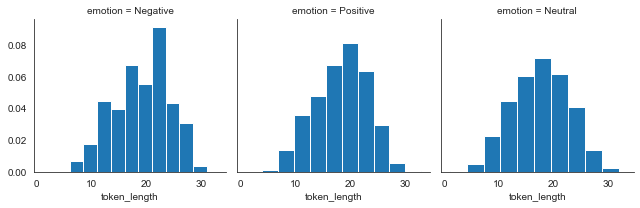

In [135]:
token_l = sns.FacetGrid(data,col='emotion')
token_l.map(plt.hist,'token_length', density=True)

Plot shows slightly more "tokens" are used in the negative emotion category versus the positive and neutral.

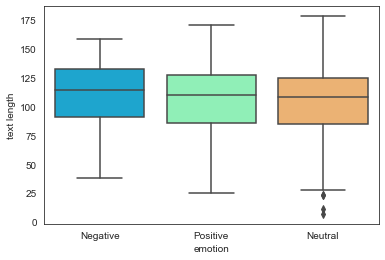

In [136]:
sns.boxplot(x='emotion',y='text length',data=data,palette='rainbow')

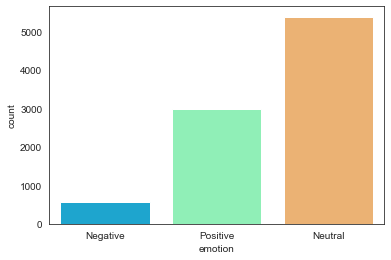

In [137]:
sns.countplot(x='emotion',data=data,palette='rainbow')

The majority of the tweets indicated "neutral" or "no emotion" towards the brand and product. The negative emotion category is significantly lower than positive and neutral categories. Adjusting for the imbalance will likely be necessary for developing a predictive model.

# Train/Test/Split

In [138]:
from sklearn.model_selection import train_test_split

X = data['tweet']
y = data['emotion']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y,test_size=0.30, random_state=123)

In [139]:
y_test.value_counts()

Neutral     1617
Positive     894
Negative     171
Name: emotion, dtype: int64

In [140]:
y_train.value_counts()

Neutral     3772
Positive    2084
Negative     399
Name: emotion, dtype: int64

# LinearSVC

In [141]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from nltk import TweetTokenizer

In [142]:
# Initialize the TweetTokenizer

tokenizer = TweetTokenizer(preserve_case=False)

In [143]:
linear_svc = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words='english',tokenizer=tokenizer.tokenize)),
                     ('clf', LinearSVC(class_weight='balanced'))])

linear_svc.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x1c2c8c89e8>>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 LinearSVC(C=1.0, class_weight='balanced', dual=T

In [144]:
predictions = linear_svc.predict(X_test)

In [149]:
# from sklearn.feature_extraction.text import CountVectorizer

# def plot_coefficients(classifier, feature_names, top_features=20):
#  coef = classifier.coef_.ravel()
#  top_positive_coefficients = np.argsort(coef)[-top_features:]
#  top_negative_coefficients = np.argsort(coef)[:top_features]
#  top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
#  # create plot
#  plt.figure(figsize=(15, 5))
#  colors = [‘red’ if c < 0 else ‘blue’ for c in coef[top_coefficients]]
#  plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
#  feature_names = np.array(feature_names)
#  plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha=’right’)
#  plt.show()
# cv = CountVectorizer()
# cv.fit(data)
# print len(cv.vocabulary_)
# print cv.get_feature_names()
# X_train = cv.transform(data)

# svm = LinearSVC()
# svm.fit(X_train, target)
# plot_coefficients(svm, cv.get_feature_names())

## Metrics

Train score= 0.9322142286171063
Test score= 0.6849366144668159

              precision    recall  f1-score   support

    Negative       0.46      0.37      0.41       171
     Neutral       0.75      0.77      0.76      1617
    Positive       0.60      0.58      0.59       894

    accuracy                           0.68      2682
   macro avg       0.60      0.58      0.59      2682
weighted avg       0.68      0.68      0.68      2682



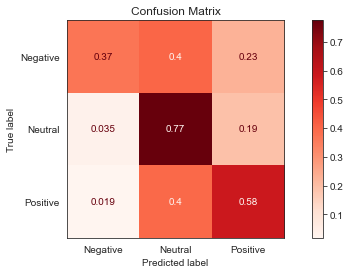

In [150]:
from sklearn import metrics

evaluate_model(linear_svc, y_train, y_test, predictions, X_train, X_test)

# MulitinomialNB

In [151]:
from sklearn.naive_bayes import MultinomialNB

In [152]:
text_mnb = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words='english',tokenizer=tokenizer.tokenize)),
                     ('clf', MultinomialNB())])

# Feed the training data through the pipeline
text_mnb.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x1c2c8c89e8>>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, cl

In [153]:
predictions = text_mnb.predict(X_test)

## Metrics

Train score= 0.750599520383693
Test score= 0.6528709917971663

              precision    recall  f1-score   support

    Negative       1.00      0.01      0.01       171
     Neutral       0.64      0.97      0.77      1617
    Positive       0.74      0.21      0.33       894

    accuracy                           0.65      2682
   macro avg       0.79      0.39      0.37      2682
weighted avg       0.70      0.65      0.58      2682



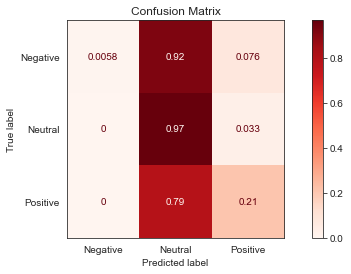

In [154]:
evaluate_model(text_mnb, y_train, y_test, predictions, X_train, X_test)

# SGDClassifier

In [155]:
from sklearn.linear_model import SGDClassifier

In [156]:
text_sgdc = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words='english',tokenizer=tokenizer.tokenize)),
                     ('clf', SGDClassifier())])


text_sgdc.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 SGDClassifier(alpha=0.0001, average=False, class_weight=None,
                               early_stopping=False, epsilon=0.1, eta0=0.0,
                               fit_intercept=True, l1_ratio=0.15,
                               learning_rate='optimal', loss='hinge',
           

In [157]:
predictions = text_sgdc.predict(X_test)

## Metrics

Train score= 0.8965627498001598
Test score= 0.6998508575689784

              precision    recall  f1-score   support

    Negative       0.66      0.27      0.38       171
     Neutral       0.73      0.84      0.78      1617
    Positive       0.63      0.52      0.57       894

    accuracy                           0.70      2682
   macro avg       0.67      0.54      0.58      2682
weighted avg       0.69      0.70      0.69      2682



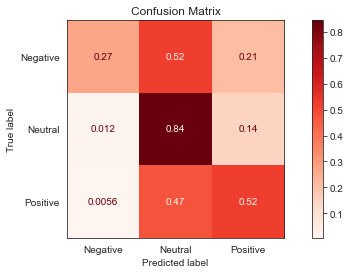

In [158]:
evaluate_model(text_sgdc, y_train, y_test, predictions, X_train, X_test)

# LogisticRegression

In [159]:
from sklearn.linear_model import LogisticRegression

In [160]:
text_lr = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words='english',tokenizer=tokenizer.tokenize)),
                     ('clf', LogisticRegression())])

text_lr.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                                 tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x1c2c8c89e8>>,
                                 use_idf=True, vocabulary=None)),
                ('clf',
                 LogisticRegression(C=1.0, class_weight=None, dua

In [161]:
predictions = text_lr.predict(X_test)

## Metrics

Train score= 0.8203037569944045
Test score= 0.6987322893363161

              precision    recall  f1-score   support

    Negative       0.63      0.07      0.13       171
     Neutral       0.71      0.88      0.79      1617
    Positive       0.65      0.49      0.56       894

    accuracy                           0.70      2682
   macro avg       0.67      0.48      0.49      2682
weighted avg       0.69      0.70      0.67      2682



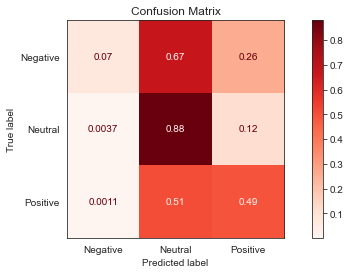

In [162]:
evaluate_model(text_lr, y_train, y_test, predictions, X_train, X_test)

# RandomForestClassifier

In [163]:
from sklearn.ensemble import RandomForestClassifier

In [164]:
text_rfc = Pipeline([('tfidf', TfidfVectorizer(lowercase=True, stop_words='english',tokenizer=tokenizer.tokenize)),
                     ('clf', RandomForestClassifier(class_weight='balanced'))])

text_rfc.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patt...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                               

In [165]:
predictions = text_rfc.predict(X_test)

## Metrics

Train score= 0.9979216626698642
Test score= 0.6812080536912751

              precision    recall  f1-score   support

    Negative       0.76      0.15      0.25       171
     Neutral       0.69      0.90      0.78      1617
    Positive       0.66      0.40      0.49       894

    accuracy                           0.68      2682
   macro avg       0.70      0.48      0.51      2682
weighted avg       0.68      0.68      0.65      2682



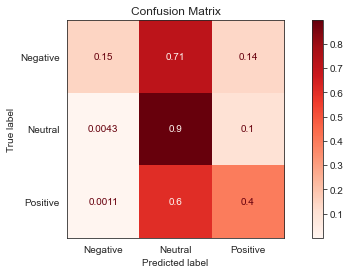

In [166]:
evaluate_model(text_rfc, y_train, y_test, predictions, X_train, X_test)

## Oversampling

In [218]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from sklearn.model_selection import GridSearchCV

tfidf = TfidfVectorizer(lowercase=True, stop_words='english',
                            tokenizer=tokenizer.tokenize)

rfc = RandomForestClassifier(class_weight='balanced')

## RFC - RandomOverSampler

In [168]:
ROS_pipeline = make_pipeline(tfidf, RandomOverSampler(random_state=123), rfc)

In [169]:
ROS_pipeline.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_

In [170]:
predictions = ROS_pipeline.predict(X_test)

### Metrics

Train score= 0.9979216626698642
Test score= 0.6845637583892618

              precision    recall  f1-score   support

    Negative       0.61      0.21      0.31       171
     Neutral       0.71      0.84      0.77      1617
    Positive       0.62      0.49      0.55       894

    accuracy                           0.68      2682
   macro avg       0.65      0.51      0.54      2682
weighted avg       0.67      0.68      0.67      2682



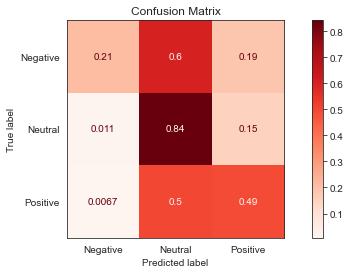

In [171]:
evaluate_model(ROS_pipeline, y_train, y_test, predictions, X_train, X_test)

In [172]:

# testing_tfidf = tfidf.fit_transform(X_train)

# ros = RandomOverSampler(random_state=777)
# X_ROS, y_ROS = ros.fit_sample(testing_tfidf, y_train)

In [173]:
# df = pd.DataFrame(y_ROS)
# df.columns = ['emotion']
# df.head()


In [174]:
# df['emotion'].value_counts()

## RFC - SMOTE

In [175]:
SMOTE_pipeline = make_pipeline(tfidf, SMOTE(random_state=123),rfc)
SMOTE_pipeline.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_

In [176]:
predictions = SMOTE_pipeline.predict(X_test)

### Metrics

Train score= 0.9979216626698642
Test score= 0.6797166293810589

              precision    recall  f1-score   support

    Negative       0.65      0.20      0.31       171
     Neutral       0.71      0.84      0.77      1617
    Positive       0.61      0.47      0.53       894

    accuracy                           0.68      2682
   macro avg       0.65      0.51      0.54      2682
weighted avg       0.67      0.68      0.66      2682



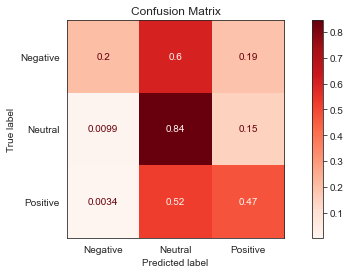

In [177]:
evaluate_model(SMOTE_pipeline, y_train, y_test, predictions, X_train, X_test)

## RFC - ADASYN

In [178]:
ADASYN_pipeline = make_pipeline(tfidf, ADASYN(ratio='minority',random_state=123),rfc)

In [179]:
ADASYN_pipeline.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_

In [180]:
predictions = ADASYN_pipeline.predict(X_test)

### Metrics

Train score= 0.997761790567546
Test score= 0.6815809097688292

              precision    recall  f1-score   support

    Negative       0.64      0.24      0.35       171
     Neutral       0.69      0.88      0.78      1617
    Positive       0.65      0.40      0.50       894

    accuracy                           0.68      2682
   macro avg       0.66      0.51      0.54      2682
weighted avg       0.67      0.68      0.66      2682



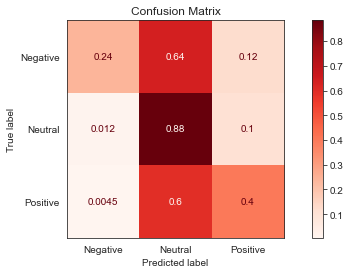

In [181]:
evaluate_model(ADASYN_pipeline, y_train, y_test, predictions, X_train, X_test)

## Undersampling

## RFC Random Under Sampler

In [182]:
from imblearn.under_sampling import NearMiss, RandomUnderSampler

RUS_pipeline = make_pipeline(tfidf, RandomUnderSampler(random_state=123),rfc)


In [183]:
RUS_pipeline.fit(X_train, y_train)  
predictions = RUS_pipeline.predict(X_test)

### Metrics

Train score= 0.5513988808952838
Test score= 0.5014914243102162

              precision    recall  f1-score   support

    Negative       0.14      0.71      0.24       171
     Neutral       0.76      0.53      0.62      1617
    Positive       0.52      0.42      0.46       894

    accuracy                           0.50      2682
   macro avg       0.48      0.55      0.44      2682
weighted avg       0.64      0.50      0.55      2682



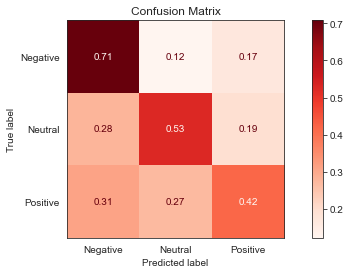

In [184]:
evaluate_model(RUS_pipeline, y_train, y_test, predictions, X_train, X_test)

## RFC - Near Miss 1

In [220]:
NM1_pipeline = make_pipeline(tfidf, NearMiss(ratio='not minority',random_state=123, version = 1),rfc)
NM1_pipeline.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_

In [222]:
predictions = NM1_pipeline.predict(X_test)

### Metrics

Train score= 0.30567545963229414
Test score= 0.2721849366144668

              precision    recall  f1-score   support

    Negative       0.10      0.79      0.17       171
     Neutral       0.78      0.13      0.22      1617
    Positive       0.37      0.43      0.40       894

    accuracy                           0.27      2682
   macro avg       0.42      0.45      0.27      2682
weighted avg       0.60      0.27      0.28      2682



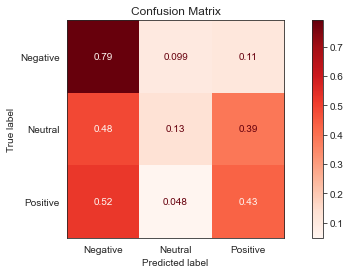

In [223]:
evaluate_model(NM1_pipeline, y_train, y_test, predictions, X_train, X_test)

## Grid_RFC - Near Miss 1

In [ ]:
params = {'criterion':['gini','entropy'],
             'max_depth':[None, 5, 3, 10],
             'min_samples_leaf': [1,2,3]}

#'max_features':['auto','sqrt',3,5,10,30,70]

In [225]:
NM1_pipeline = make_pipeline(tfidf, NearMiss(ratio='not minority',random_state=123, version = 1),rfc)
 
grid = GridSearchCV(NM1_pipeline, cv=5, n_jobs=-1, param_grid=params ,scoring=None)
grid.fit(X_train, y_train)

ValueError: Invalid parameter criterion for estimator Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [226]:
grid.score(X_test, y_test)

AttributeError: 'GridSearchCV' object has no attribute 'scorer_'

In [227]:
grid.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [ ]:
best_tree = RandomForestClassifier(**grid.best_params_)

In [ ]:
best_tree.fit(X_train,y_train)

In [ ]:
predictions = best_tree.predict(X_test)

### Metrics

Train score= 0.30567545963229414
Test score= 0.2721849366144668

              precision    recall  f1-score   support

    Negative       0.10      0.79      0.17       171
     Neutral       0.78      0.13      0.22      1617
    Positive       0.37      0.43      0.40       894

    accuracy                           0.27      2682
   macro avg       0.42      0.45      0.27      2682
weighted avg       0.60      0.27      0.28      2682



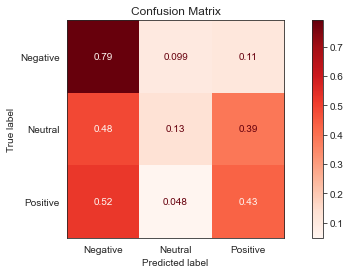

In [223]:
evaluate_model(best_tree, y_train, y_test, predictions, X_train, X_test)

## RFC - Near Miss 2

In [189]:
NM2_pipeline = make_pipeline(tfidf, NearMiss(ratio='not minority',random_state=123, version = 2),rfc)
NM2_pipeline.fit(X_train, y_train)  

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_

In [190]:
predictions = NM2_pipeline.predict(X_test)

### Metrics

Train score= 0.302158273381295
Test score= 0.302386278896346

              precision    recall  f1-score   support

    Negative       0.09      0.74      0.16       171
     Neutral       0.77      0.21      0.33      1617
    Positive       0.43      0.38      0.41       894

    accuracy                           0.30      2682
   macro avg       0.43      0.44      0.30      2682
weighted avg       0.62      0.30      0.35      2682



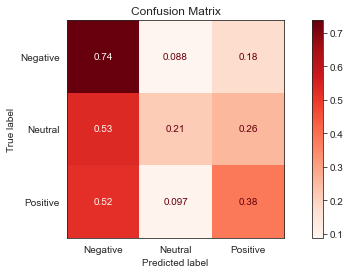

In [191]:
evaluate_model(NM2_pipeline, y_train, y_test, predictions, X_train, X_test)

## RFC - Near Miss 3

In [192]:
NM3_pipeline = make_pipeline(tfidf, NearMiss(ratio='not minority',random_state=123, version = 3, n_neighbors_ver3=4),rfc)
NM3_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_

In [193]:
predictions = NM3_pipeline.predict(X_test)

### Metrics

Train score= 0.5223021582733813
Test score= 0.48135719612229677

              precision    recall  f1-score   support

    Negative       0.13      0.65      0.21       171
     Neutral       0.73      0.50      0.60      1617
    Positive       0.54      0.41      0.46       894

    accuracy                           0.48      2682
   macro avg       0.46      0.52      0.42      2682
weighted avg       0.63      0.48      0.53      2682



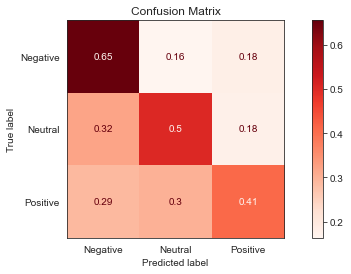

In [194]:
evaluate_model(NM3_pipeline, y_train, y_test, predictions, X_train, X_test)

In [195]:
# tfid = TfidfVectorizer()

In [196]:
# tokenizer = TweetTokenizer()

In [197]:
# tfid = TfidfVectorizer(tokenizer=tokenizer.tokenize)

In [198]:
# tweets = tfid.fit_transform(data['tweet'])

In [199]:
# tfid.inverse_transform(tweets)

In [200]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/srn/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [201]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

In [202]:
data.head()

,tweet,product,emotion,text length,token_length
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,127,24
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,139,22
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,79,15
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,82,15
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,131,17


In [203]:
data['scores'] = data['tweet'].apply(lambda tweet: sid.polarity_scores(tweet))

In [204]:
data.head()

,tweet,product,emotion,text length,token_length,scores
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,127,24,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'comp..."
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,139,22,"{'neg': 0.0, 'neu': 0.576, 'pos': 0.424, 'comp..."
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,79,15,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,82,15,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp..."
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,131,17,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'comp..."


In [205]:

data['compound']= data['scores'].apply(lambda score_dict: score_dict['compound'])

In [ ]:
data.head()

In [206]:
def emotion_p(c):
    if c >=0.2: 
        output = 'Positive'
    elif c <=-0.2:
        output = 'Negative'
    else:
        output = 'Neutral'
    return output
    

In [207]:
emotion_p(0)

'Neutral'

In [208]:
data['comp_score'] = data['compound'].apply(emotion_p)

In [209]:
data.head()

,tweet,product,emotion,text length,token_length,scores,compound,comp_score
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,127,24,"{'neg': 0.203, 'neu': 0.797, 'pos': 0.0, 'comp...",-0.6800,Negative
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,139,22,"{'neg': 0.0, 'neu': 0.576, 'pos': 0.424, 'comp...",0.9100,Positive
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,79,15,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,Neutral
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,82,15,"{'neg': 0.0, 'neu': 0.663, 'pos': 0.337, 'comp...",0.7269,Positive
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,131,17,"{'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'comp...",0.6249,Positive


In [210]:
data['product'].value_counts()

unknown                            5655
iPad                                942
Apple                               659
iPad or iPhone App                  470
Google                              429
iPhone                              296
Other Google product or service     292
Android App                          81
Android                              78
Other Apple product or service       35
Name: product, dtype: int64

In [211]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

In [212]:
accuracy_score(data['emotion'],data['comp_score'])

0.5490656819961955